TokaMaker Example: Predicting currents and forces induced during a CQ in ITER {#doc_tMaker_ITER_ex5}
==========
In this example we show how to compute eddy currents and resulting forces from a simplified disruptive current quench in ITER. 

This example utilizes the mesh built in \ref doc_tMaker_ITER_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_power_flux_fun, compute_forces_components

## Compute pre-CQ equilibrium
Now we compute the same equilibrium as in \ref doc_tMaker_ITER_ex2.

In [3]:
# Initialize TokaMaker object
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

# Load mesh into TokaMaker
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('ITER_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 = 5.3*6.2)

# Define a vertical stability coil
mygs.set_coil_vsc({'VS': 1.0})

# Define hard limits on coil currents
coil_bounds = {key: [-50.E6, 50.E6] for key in mygs.coil_sets}
mygs.set_coil_bounds(coil_bounds)

# Define global targets
Ip_target=15.6E6
P0_target=6.2E5
mygs.set_targets(Ip=Ip_target, pax=P0_target)

# Define shape targets
isoflux_pts = np.array([
    [ 8.20,  0.41],
    [ 8.06,  1.46],
    [ 7.51,  2.62],
    [ 6.14,  3.78],
    [ 4.51,  3.02],
    [ 4.26,  1.33],
    [ 4.28,  0.08],
    [ 4.49, -1.34],
    [ 7.28, -1.89],
    [ 8.00, -0.68]
])
x_point = np.array([[5.125, -3.4],])
mygs.set_isoflux(np.vstack((isoflux_pts,x_point)))
mygs.set_saddles(x_point)

# Set coil regularization matrix
regularization_terms = []
for name, coil in mygs.coil_sets.items():
    if name.startswith('CS'):
        if name.startswith('CS1'):
            regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=2.E-2))
        else:
            regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E-2))
    elif name.startswith('PF'):
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E-2))
    elif name.startswith('VS'):
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=0.0,weight=1.E-2))
regularization_terms.append(mygs.coil_reg_term({'#VSC': 1.0},target=0.0,weight=1.E2))
mygs.set_coil_reg(reg_terms=regularization_terms)

# Set F*F' and P' profiles
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,4.0,1.0)
mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

# Compute equilibrium
R0 = 6.3
Z0 = 0.5
a = 2.0
kappa = 1.4
delta = 0.0
mygs.init_psi(R0, Z0, a, kappa, delta)
mygs.solve()
psi_full = mygs.get_psi(normalized=False)
psi_lim = mygs.psi_bounds[0]

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_diverted_geo
Revision id:          08c4e26
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_63051/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.859E+02
    # of points  =    4757
    # of edges   =   14156
    # of cells   =    9400
    # of boundary points =     112
    # of boundary edges  =     112
    # of boundary cells  =     112
  Resolution statistics:
    hmin =  9.924E-03
    hrms =  2.826E-01
    hmax =  8.466E-01
  Surface grounded at vertex     870


**** Creating Lagrange FE spa

### Print information and plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi()" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints()" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.5600E+07
  Current Centroid [m]    =    6.203  0.530
  Magnetic Axis [m]       =    6.362  0.533
  Elongation              =    1.875 (U:  1.763, L:  1.987)
  Triangularity           =    0.479 (U:  0.409, L:  0.549)
  Plasma Volume [m^3]     =   820.079
  q_0, q_95               =    0.823  2.760
  Peak Pressure [Pa]      =    6.1923E+05
  Stored Energy [J]       =    2.4299E+08
  <Beta_pol> [%]          =   42.7111
  <Beta_tor> [%]          =    1.7801
  <Beta_n>   [%]          =    1.1953
  Diamagnetic flux [Wb]   =    1.5403E+00
  Toroidal flux [Wb]      =    1.2187E+02
  l_i                     =    1.1605

Coil Currents [MA]:
  CS3U:           13.74
  CS2U:            9.74
  CS1U:           -9.06
  CS1L:           -8.81
  CS2L:           13.40
  CS3L:           17.88
  PF1:            12.94
  PF2:            -2.20
  PF3:            -5.95
  PF4:            -5.14
  PF5:            -5.18


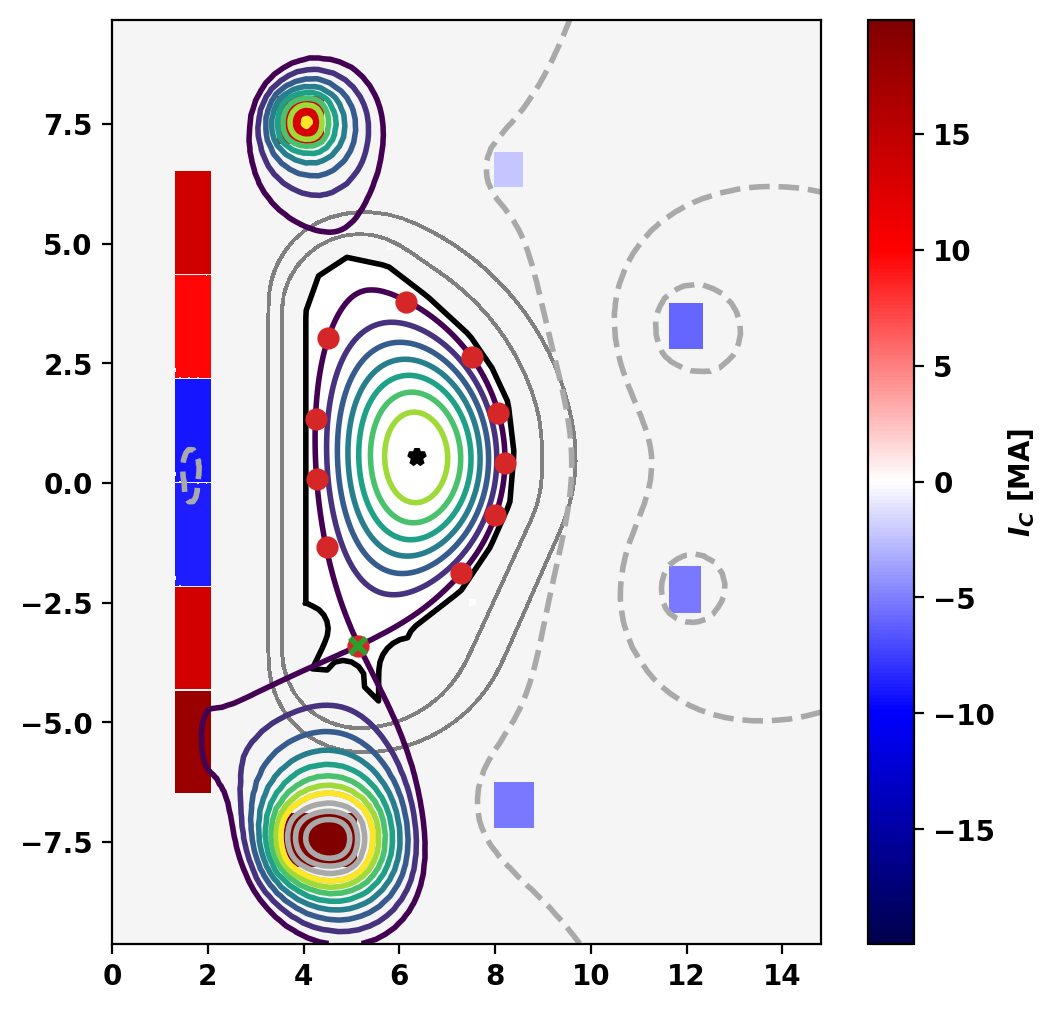

In [4]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='o')

mygs.print_info()
print()
print("Coil Currents [MA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    print('  {0:10} {1:10.2F}'.format(key+":",current/1.E6))

## Compute eddy currents and forces for a simple current quench
TokaMaker can be used to evaluate some of the impacts caused by the Current Quench (CQ) that occurs following a disruption in tokamaks. During the CQ the plasma current rapidly falls due to high resistivity following the thermal quench. In real CQs the plasma current profile significantly evolves during this quench, due to changes in pressure and temperature profiles and plasma motions, such as VDEs. However, for first order approximation we can model the eddy currents and voltages produced by the CQ by simply decreasing the flux corresponding to the plasma current over a given timescale.

### Extract flux from plasma current only
To do this we first need to separate the flux corresponding to the plasma current, which changes during the CQ, from the vacuum flux produced by the coils, which does not change (if the coil currents remain fixed) over the CQ. This can be done by performing a vacuum solve (\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.vac_solve "vac_solve()") to get the vacuum flux from the coils and then subtracting this from the full flux to isolate the plasma contribution.

**Note:** This is meant to act as a first order model of inductive CQ impacts and additional effects related to the detailed evolution of the plasma current, coil currents, and other dynamics will be important for detailed analysis and/or predicitons.

   1  4.2217E+06


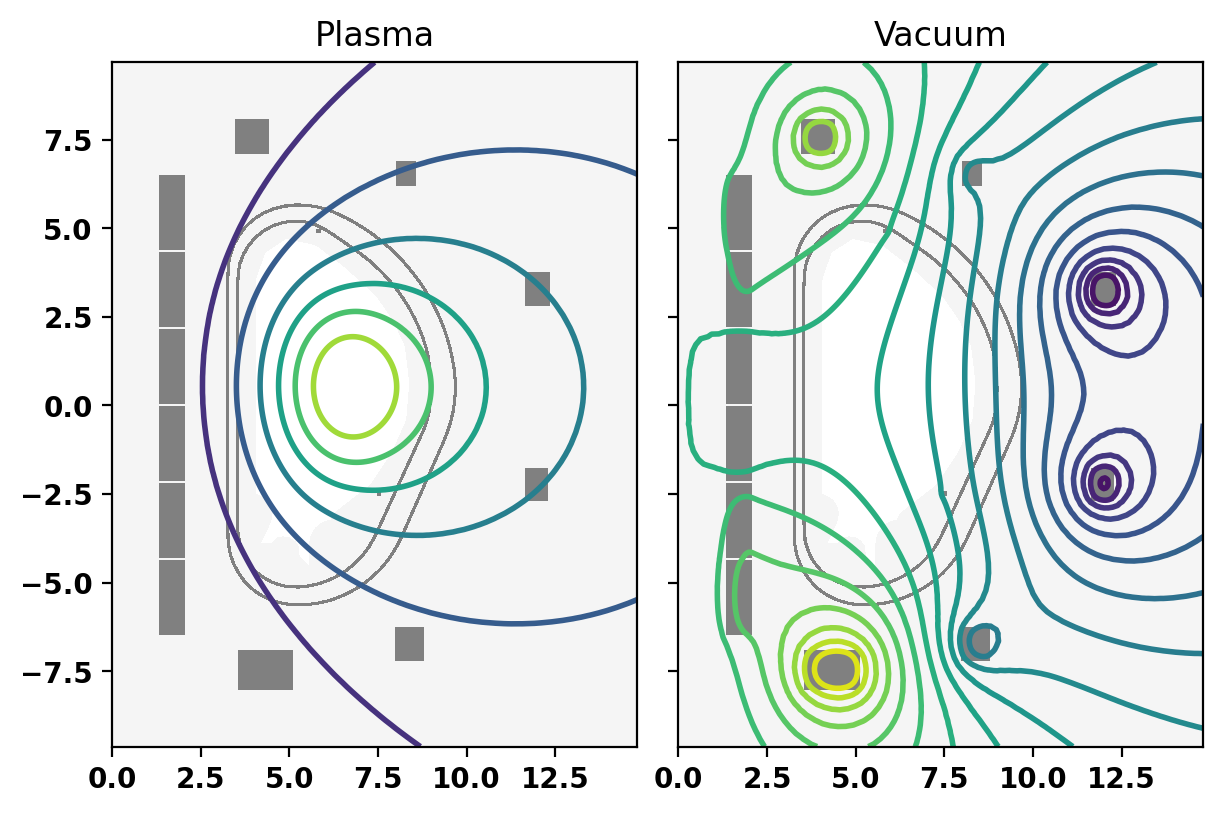

In [5]:
# Compute flux from coils only
mygs.set_psi(0.0*psi_full)
psi_vac = mygs.vac_solve()
# Subtract to yield flux from plasma current
psi_plasma = psi_full-psi_vac
# Save coil currents
coil_currents, _ = mygs.get_coil_currents()

# Plot isolated plasma flux
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True)
mygs.plot_machine(fig,ax[0],limiter_color=None)
mygs.plot_psi(fig,ax[0],psi_plasma,normalized=False,xpoint_color=None,opoint_color=None)
ax[0].set_title('Plasma')
mygs.plot_machine(fig,ax[1],coil_colormap=None,limiter_color=None)
mygs.plot_psi(fig,ax[1],psi=psi_vac,normalized=False,plasma_nlevels=20,vacuum_levels=None,xpoint_color=None,opoint_color=None)
_ = ax[1].set_title('Vacuum')

### Perform time-dependent simulation with plasma-current quench source
With the flux separated into constituent components a time-dependent simulation may now be performed to compute the evolution of eddy current in conducting structures in response to the loop voltage generated by the CQ. 

In [6]:
# Set linear CQ time
CQ_time = 20.0E-3

# Setup simulation
psi_last = np.zeros((mygs.np))
t = 0.0
dt = CQ_time/20.0
results = [psi_vac+psi_plasma]
sim_time = [0.0]
mygs.settings.pm=False
mygs.update_settings()
mygs.set_coil_currents()
for i in range(100):
    if i == 40:
        dt = CQ_time/5.0
    # Set source from last time step w/ or w/o CQ source
    if t <= CQ_time:
        mygs.set_psi_dt(psi_plasma*dt/CQ_time+psi_last,dt)
    else:
        mygs.set_psi_dt(psi_last,dt)
    
    # Compute next time step
    mygs.set_psi(0.0*psi_last) # Necessary temporarily to initialize zero flux for vacuum solves
    psi_last = mygs.vac_solve()
    t += dt
    
    # Save timestep for plotting
    results.append(psi_vac+psi_last+psi_plasma*max(0.0,1.0-t/CQ_time))
    sim_time.append(t)
# Convert to NumPy array
sim_time = np.array(sim_time)

# Get index of sampling times
ind_sample = (abs(sim_time-CQ_time/2.0)).argmin()
ind_sample2 = (abs(sim_time-CQ_time*2.0)).argmin()

### Plot results

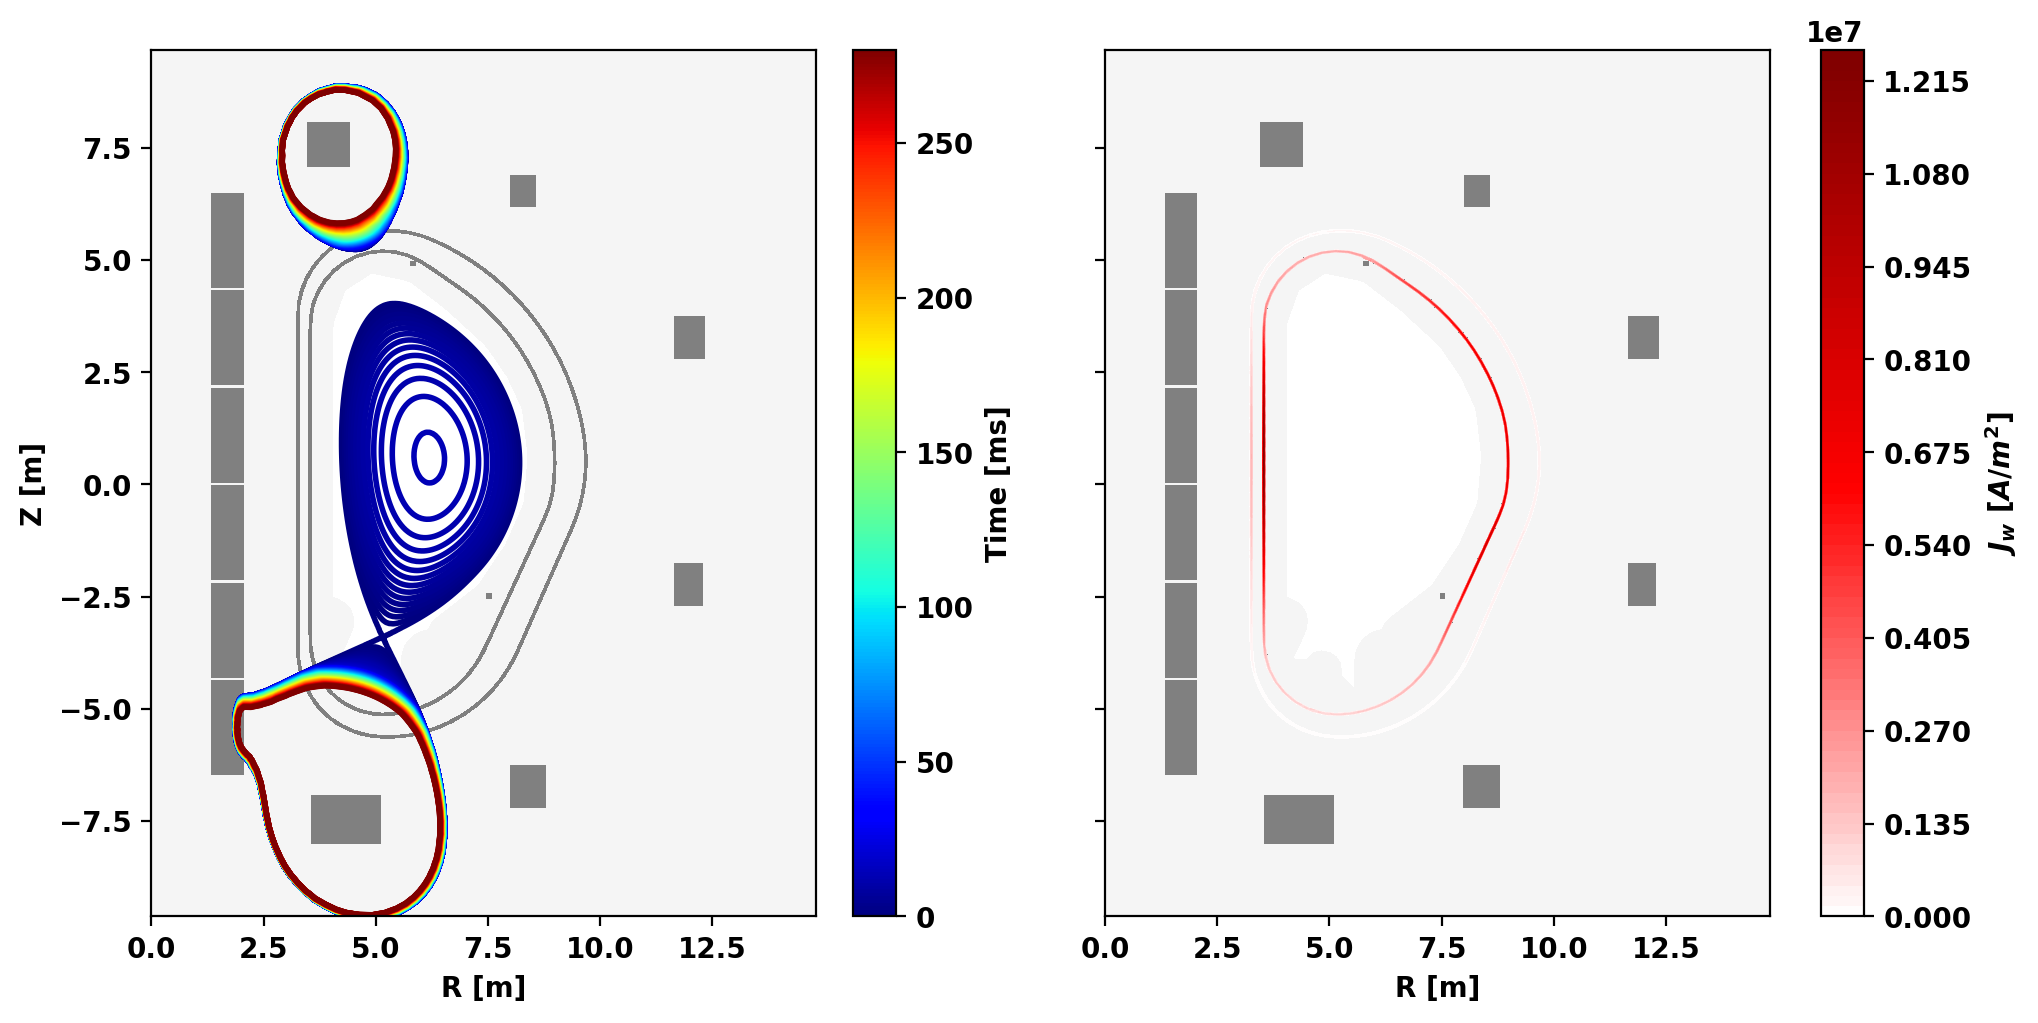

In [7]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,5),constrained_layout=True)

# Plot flux evolution in time
mygs.plot_machine(fig,ax[0],coil_colormap=None,limiter_color=None)
colors = plt.cm.jet(sim_time/sim_time[-1]) #np.linspace(0.0, sim_time[-1], len(results)))
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax[0],psi=result,normalized=False,plasma_levels=[psi_lim],plasma_color=[colors[i]],vacuum_levels=None,xpoint_color=None,opoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time[-1]*1.E3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet),ax=ax[0],label='Time [ms]')

# Plot snapshot at t=10 ms
mygs.plot_machine(fig,ax[1],coil_colormap=None,limiter_color=None)
mygs.plot_eddy(fig,ax[1],psi=results[ind_sample],colormap='seismic',symmap=True,nlevels=100)

# Format plots
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
_ = ax[-1].set_xlabel('R [m]')

### Plot loop voltage

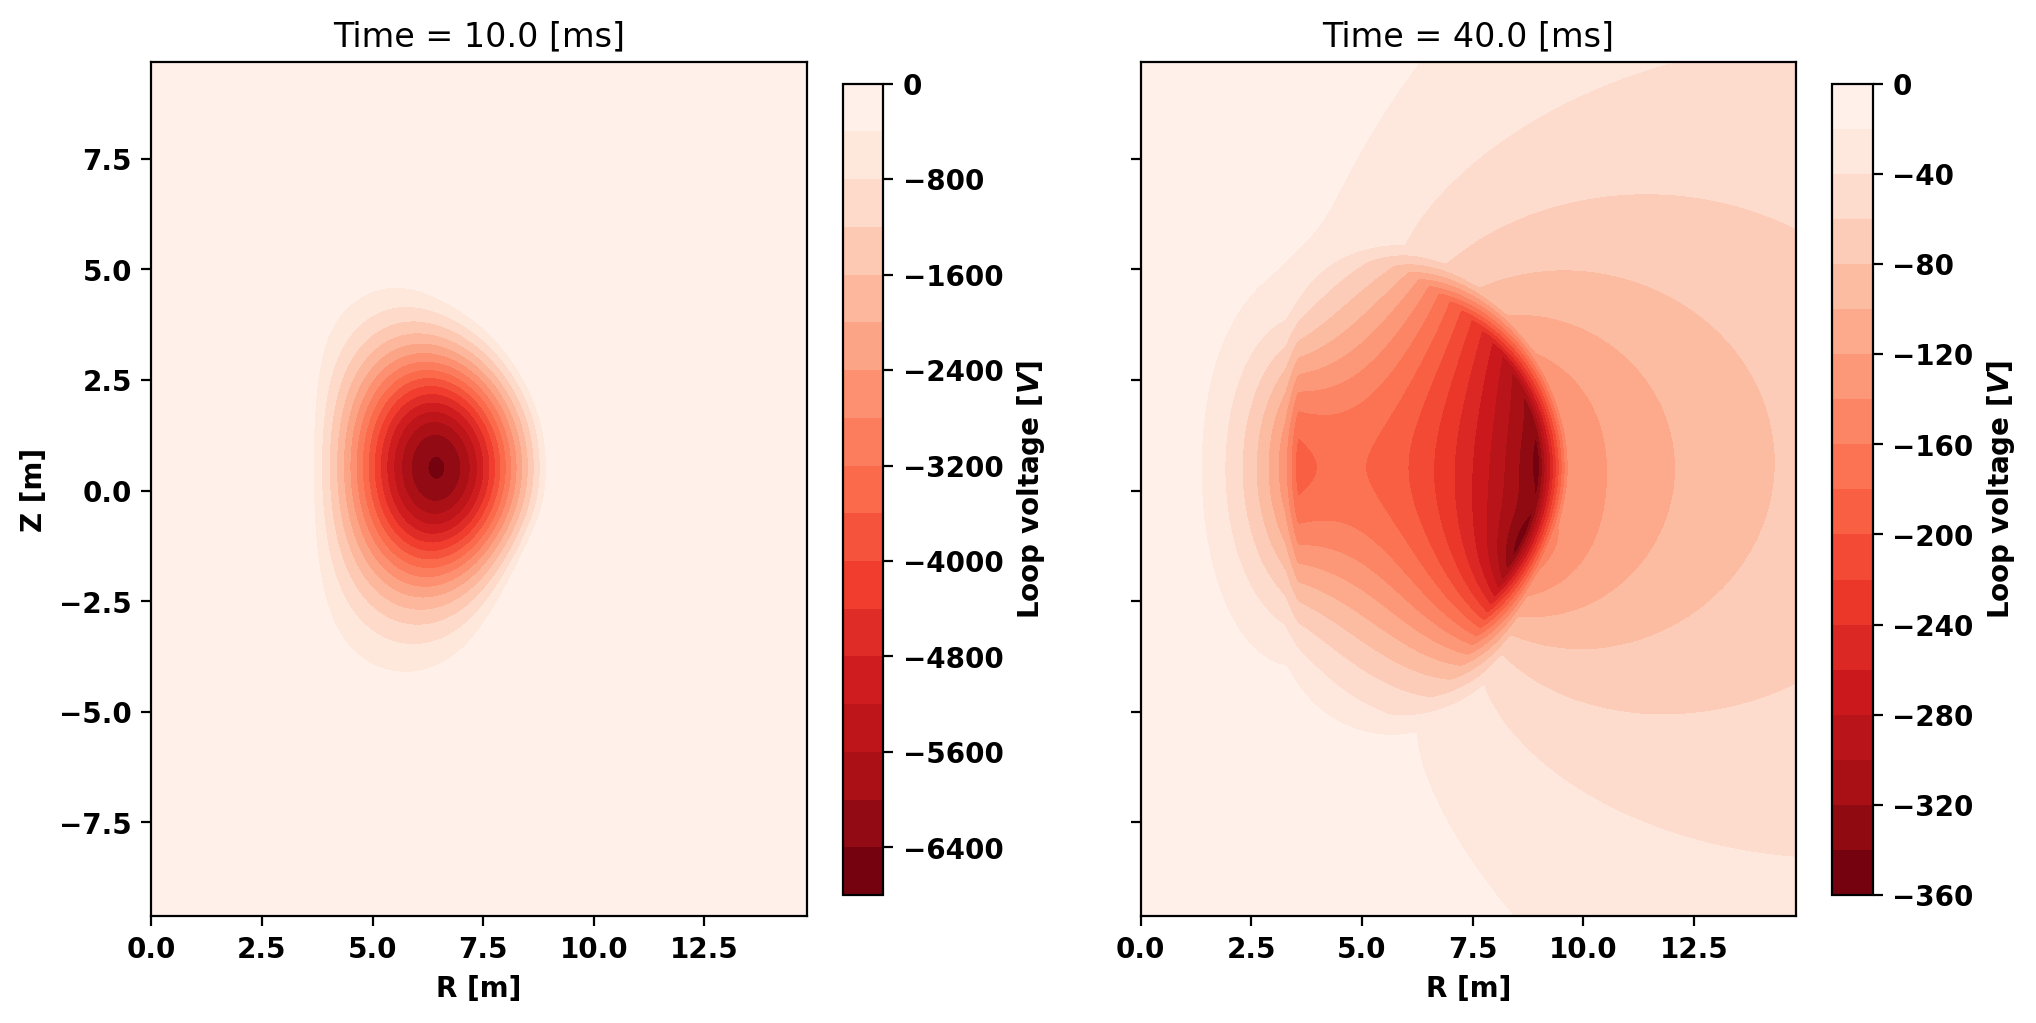

In [8]:
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True,constrained_layout=True)

# Plot at t = 10 ms
dpsi_dt = (results[ind_sample+1]-results[ind_sample-1])/(sim_time[ind_sample+1]-sim_time[ind_sample-1])
clf = ax[0].tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc,2.0*np.pi*dpsi_dt,levels=20,cmap='Reds_r')
fig.colorbar(clf,ax=ax[0],label=r'Loop voltage [$V$]', shrink=0.95)
ax[0].set_title('Time = {0:.1f} [ms]'.format(sim_time[ind_sample]*1.E3))

# Plot at t = 40 ms
dpsi_dt = (results[ind_sample2+1]-results[ind_sample2-1])/(sim_time[ind_sample2+1]-sim_time[ind_sample2-1])
clf = ax[1].tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc,2.0*np.pi*dpsi_dt,levels=20,cmap='Reds_r')
fig.colorbar(clf,ax=ax[1],label=r'Loop voltage [$V$]', shrink=0.95)
ax[1].set_title('Time = {0:.1f} [ms]'.format(sim_time[ind_sample2]*1.E3))

# Format plots
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
_ = ax[1].set_xlabel('R [m]')
for ax_tmp in ax:
    ax_tmp.set_aspect('equal','box')

### Compute and plot forces

In [9]:
Fr_inner = np.zeros((len(results),))
Fr_outer = np.zeros((len(results),))
for i, result in enumerate(results):
    mesh_currents, Bv_cond, mask, rcc = compute_forces_components(mygs,results[i])
    Fr_inner[i] = mygs.area_integral(mesh_currents*mygs.r[:,0]*Bv_cond[:,2],reg_mask=cond_dict['VV1']['reg_id'])
    Fr_outer[i] = mygs.area_integral(mesh_currents*mygs.r[:,0]*Bv_cond[:,2],reg_mask=cond_dict['VV2']['reg_id'])

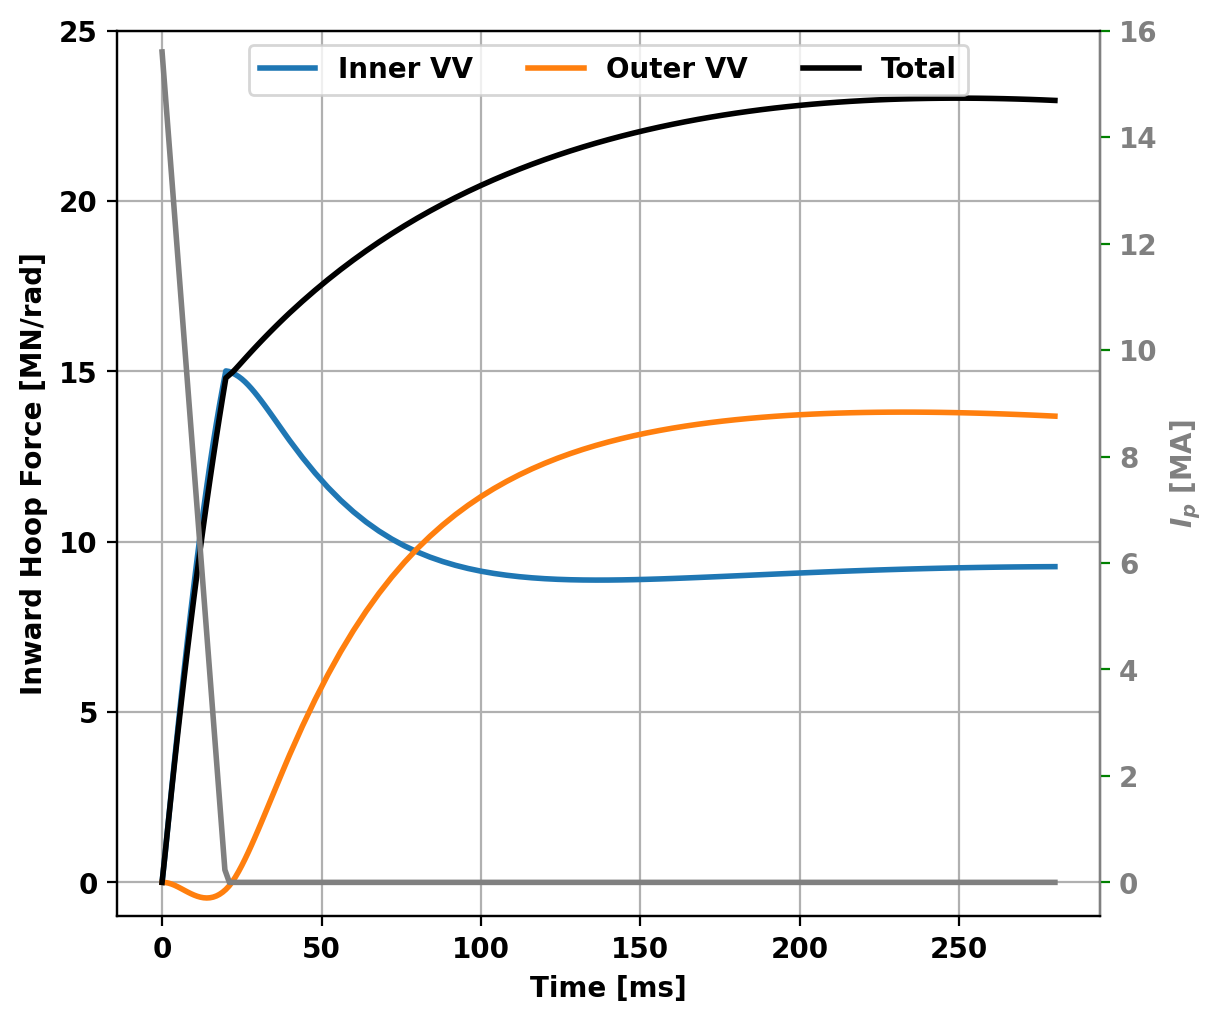

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,5),constrained_layout=True)

# Plot plasma current
x = np.linspace(0.0,sim_time[-1]*1.E3,200)
y = np.zeros_like(x); y[x<CQ_time*1.E3] = (CQ_time*1.E3-x[x<CQ_time*1.E3])*Ip_target/1.E6/(CQ_time*1.E3)
ax2 = ax.twinx()
ax2.plot(x,y,label=r'$I_P$',color='0.5')

# Plot forces
ax.plot(np.asarray(sim_time)*1.E3,-np.asarray(Fr_inner)/1.E6,label='Inner VV')
ax.plot(np.asarray(sim_time)*1.E3,-np.asarray(Fr_outer)/1.E6,label='Outer VV')
ax.plot(np.asarray(sim_time)*1.E3,-(np.asarray(Fr_inner)+np.asarray(Fr_outer))/1.E6,'k',label='Total')

# Format plot
ax.grid(True)
ax.set_ylim(-1,25)
ax2.set_ylim(-16/25.,16)
ax.legend(loc='upper center',ncols=3)
ax.set_ylabel(r'Inward Hoop Force [MN/rad]')
ax2.set_ylabel(r'$I_p$ [MA]',color='0.5')
ax2.tick_params(color='green', labelcolor='0.5')
ax2.spines['right'].set_edgecolor('0.5')
_ = ax.set_xlabel(r'Time [ms]')

In [11]:
def plot_CQ(fig, ax, psi, time):
    # Get currents and field in conducting regions
    J_cond, Bv_cond, mask, rcc = compute_forces_components(mygs,psi,cell_centered=True)
    
    # Plot current density
    Jphi = J_cond[mask]
    Jphi /= 1.E6
    vmax = max(1.E0,abs(Jphi).max())
    mygs.plot_psi(fig,ax[0],psi=psi,normalized=False,plasma_levels=[psi_lim],plasma_color=['0.5'],vacuum_levels=None,xpoint_color=None,opoint_color=None)
    clf2 = ax[0].tripcolor(mygs.r[:,0],mygs.r[:,1],mygs.lc[mask],Jphi,cmap='Reds', vmin=0.0, vmax=vmax)
    cb1 = fig.colorbar(clf2,ax=ax[0],label=r'Toroidal Current Density [$MA/m^2$]',format='{x:6.1f}',shrink=0.95)
    
    # Radial force
    Fr = J_cond[mask]*Bv_cond[mask,2]
    Fr /= 1.E6
    vmax = abs(Fr).max()
    mygs.plot_psi(fig,ax[1],psi=psi,normalized=False,plasma_levels=[psi_lim],plasma_color=['0.5'],vacuum_levels=None,xpoint_color=None,opoint_color=None)
    clf = ax[1].tripcolor(mygs.r[:,0],mygs.r[:,1],mygs.lc[mask],Fr,cmap='seismic', vmin=-vmax, vmax=vmax)
    cb2 = fig.colorbar(clf,ax=ax[1],label=r'Radial Force per unit volume [$MN/m^3$]', shrink=0.95)
    
    # Vertical force
    Fz = -J_cond[mask]*Bv_cond[mask,0]
    Fz /= 1.E6
    vmax = abs(Fz).max()
    mygs.plot_psi(fig,ax[2],psi=psi,normalized=False,plasma_levels=[psi_lim],plasma_color=['0.5'],vacuum_levels=None,xpoint_color=None,opoint_color=None)
    clf = ax[2].tripcolor(mygs.r[:,0],mygs.r[:,1],mygs.lc[mask],Fz,cmap='seismic', vmin=-vmax, vmax=vmax)
    cb3 = fig.colorbar(clf,ax=ax[2],label=r'Vertical Force per unit volume [$MN/m^3$]', shrink=0.95)
    
    # Format plots
    fig.suptitle('Time = {0:.1f} [ms]'.format(time*1.E3),fontsize=20)
    ax[0].set_ylabel('Z [m]')
    ax[0].set_xlabel('R [m]')
    _ = ax[1].set_xlabel('R [m]')
    for ax_tmp in ax:
        ax_tmp.set_aspect('equal','box')

    return cb1, cb2, cb3

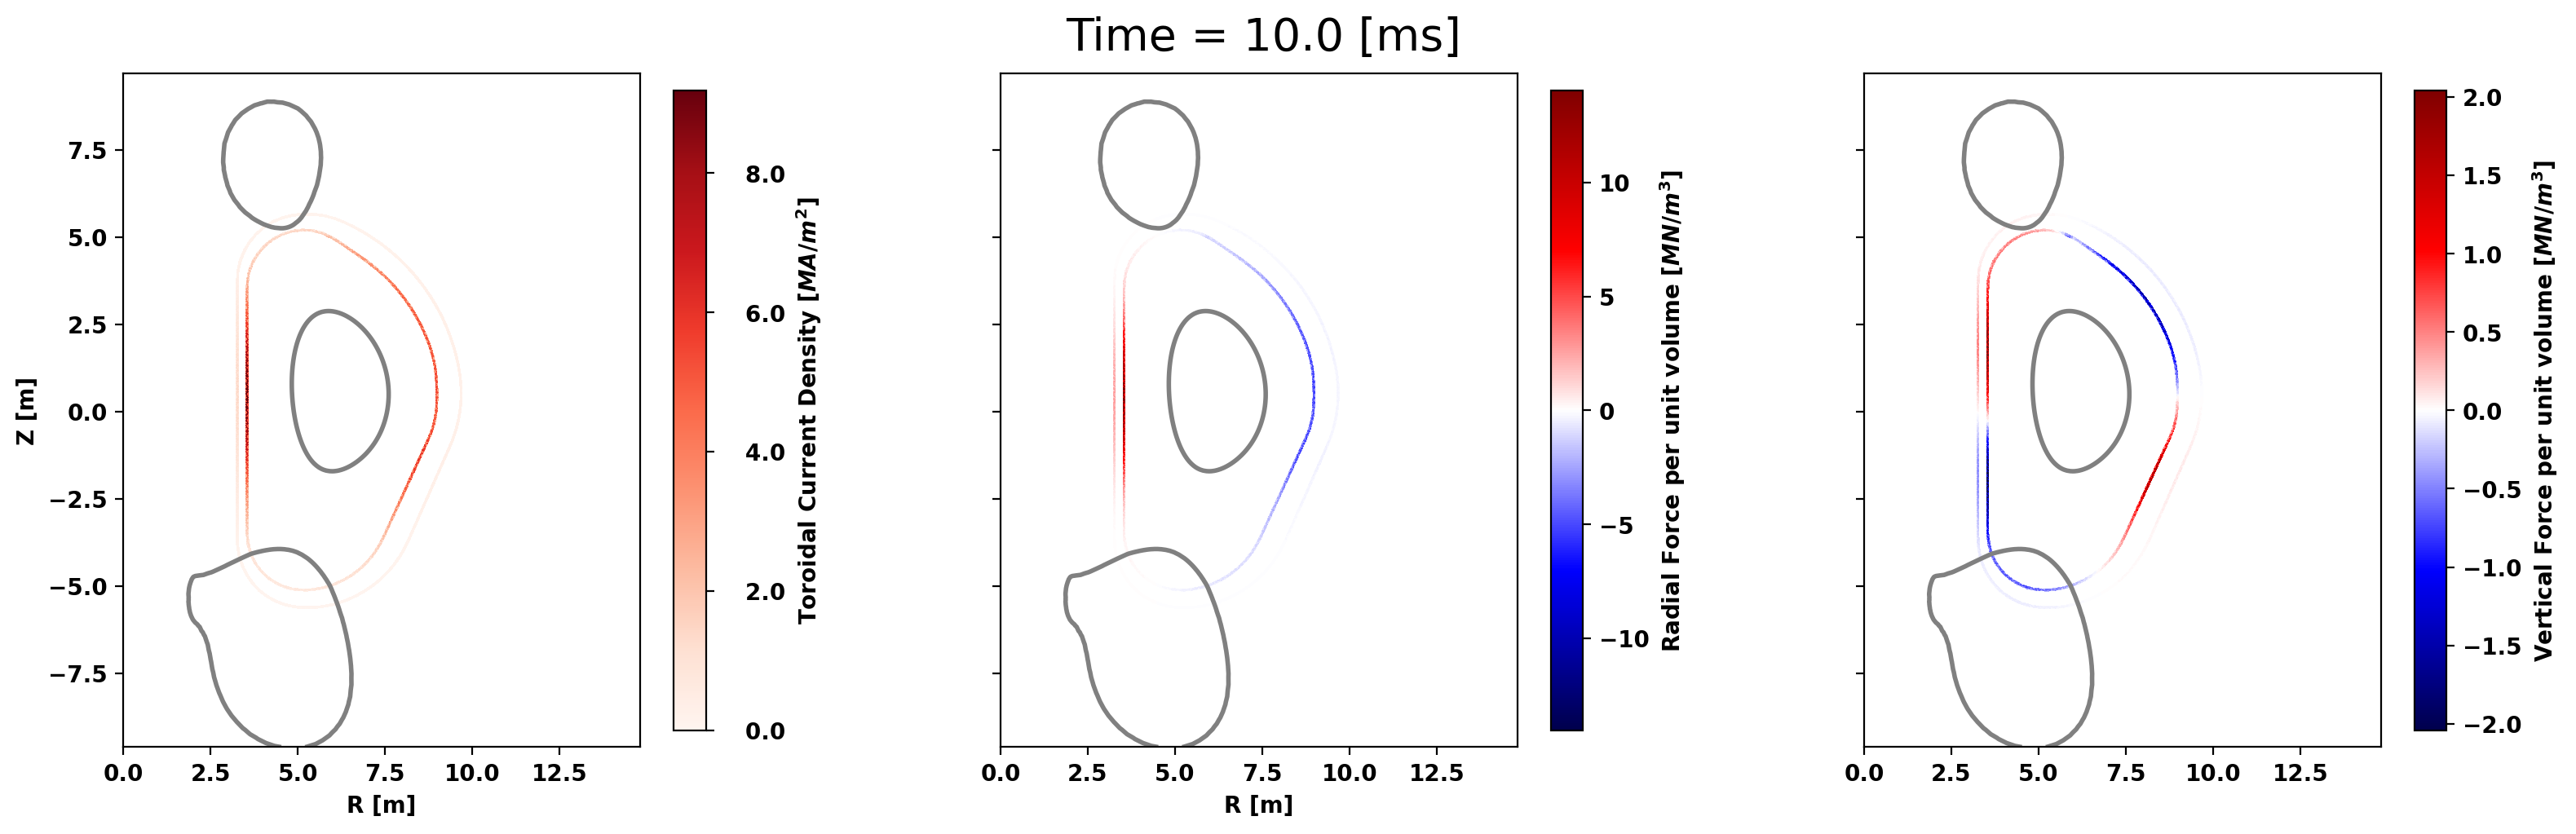

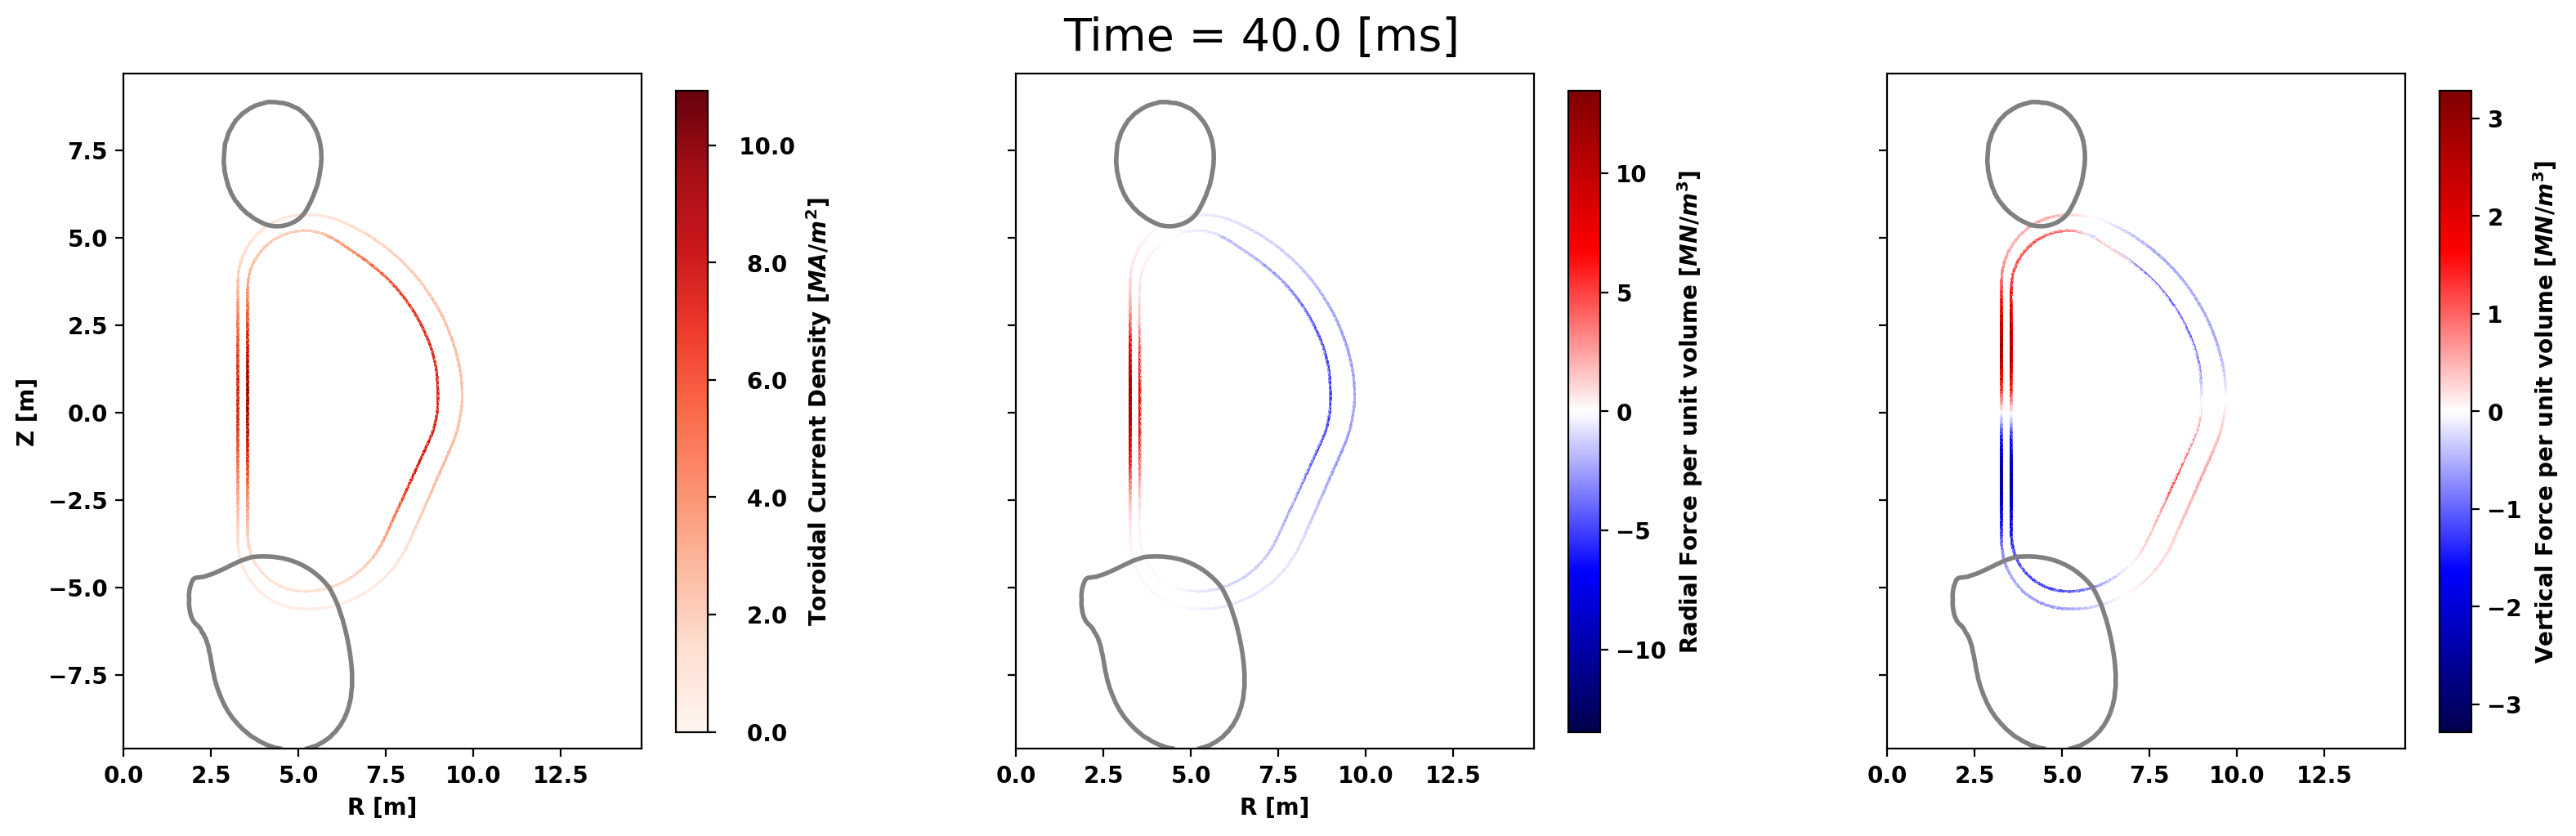

In [12]:
# Plot results
fig, ax = plt.subplots(1,3,figsize=(16,5),sharey=True,constrained_layout=True)
_ = plot_CQ(fig, ax, results[ind_sample], sim_time[ind_sample])

fig, ax = plt.subplots(1,3,figsize=(16,5),sharey=True,constrained_layout=True)
_ = plot_CQ(fig, ax, results[ind_sample2], sim_time[ind_sample2])

### Create animation of simulation

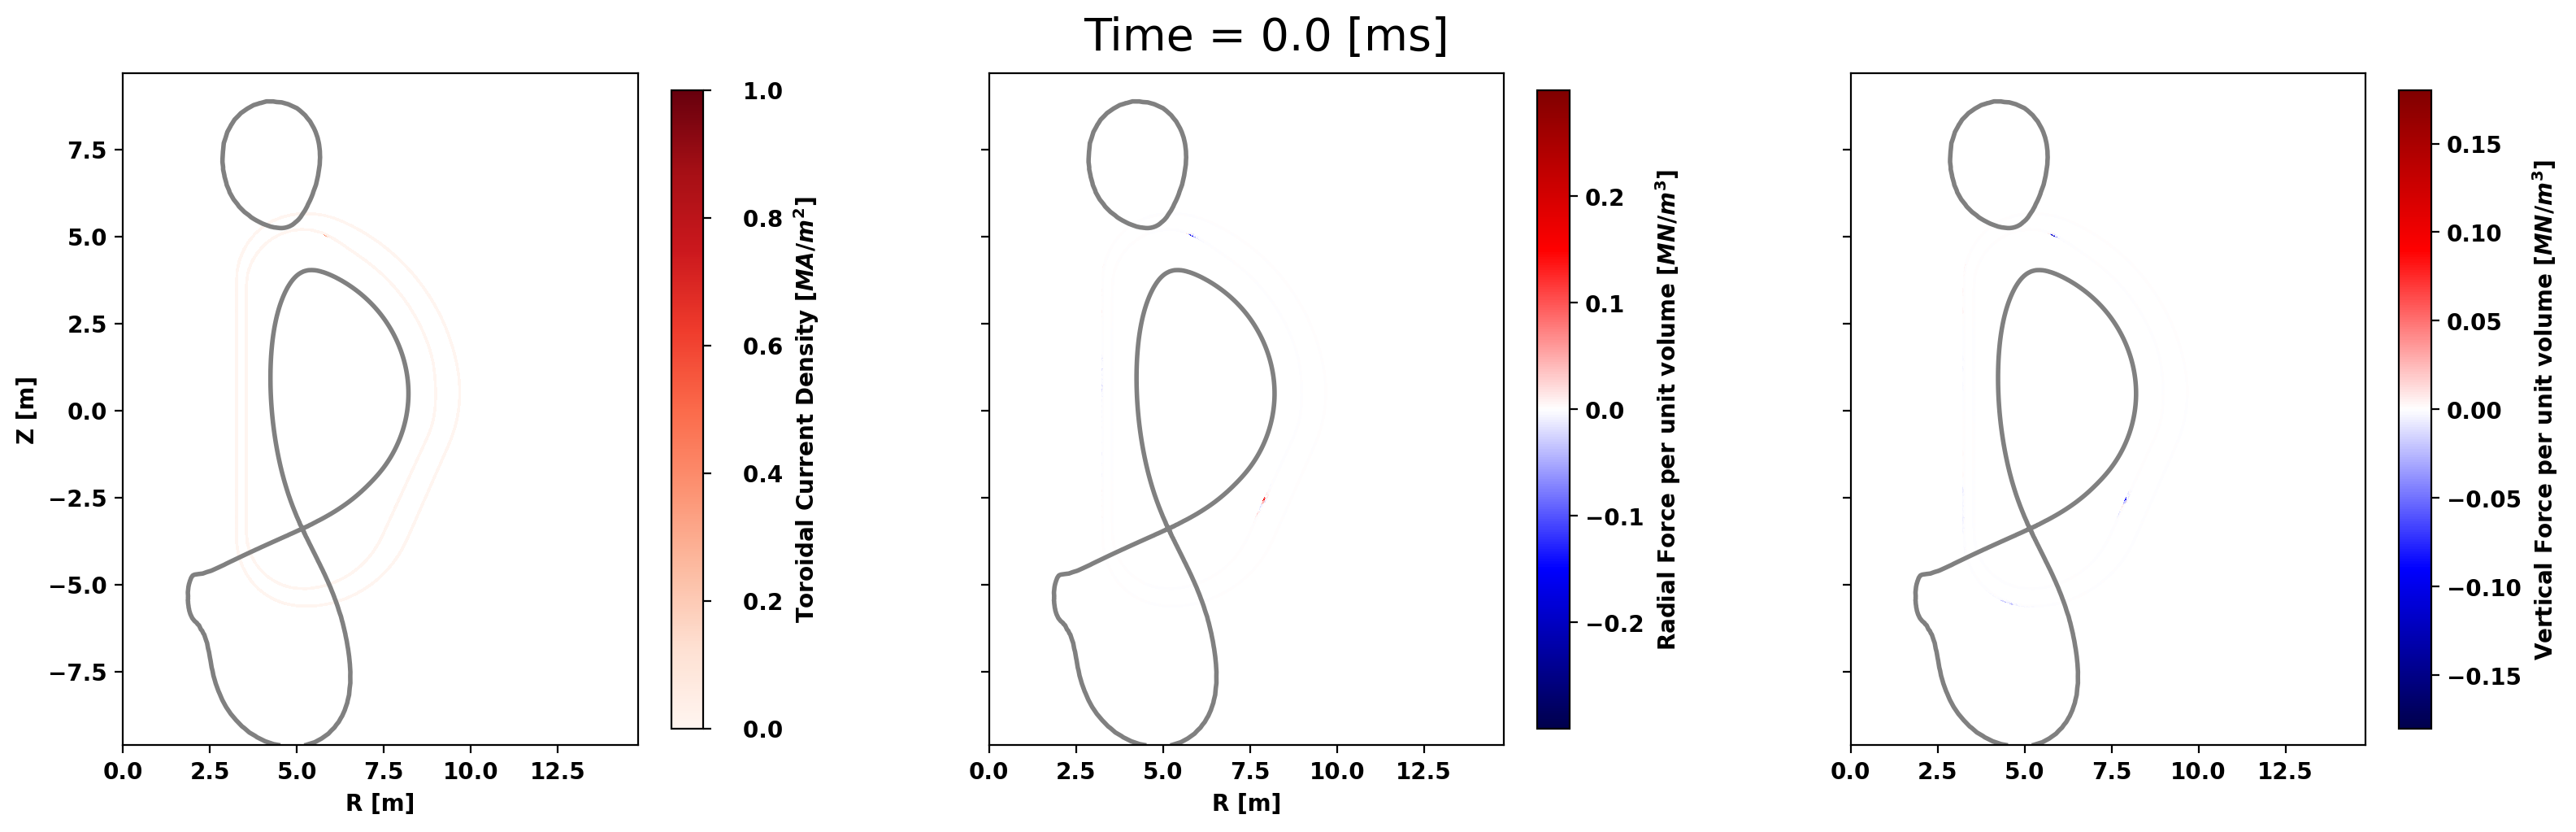

In [13]:
import matplotlib.animation

fig, ax = plt.subplots(1,3,figsize=(16,5),sharey=True,constrained_layout=True)
cbs = [None, None, None]

def animate(ii):
    # Clear figure
    global cbs
    for cb in cbs:
        if cb is not None:
            cb.remove()
    for ax_tmp in ax:
        ax_tmp.clear()

    # Plot time point
    cbs[0], cbs[1], cbs[2] = plot_CQ(fig, ax, results[ii], sim_time[ii])

# Save as GIF
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=40)
ani.save('ITER_CQ.gif',dpi=200,fps=10)